In [56]:
from soam.workflow import TimeSeriesExtractor
from muttlib.dbconn import BigQueryClient
import pandas as pd

In [57]:
db = "COSTS"
table =  "LK_GOOGLE_TOOLS_COST"
project = "meli-marketing"
bqcli = BigQueryClient(auth_file="meli-roioptimizer/pomopt/configs/bigquery_secret.json", db=db, table=table, project= project, auth=None)
tsstep = TimeSeriesExtractor(bqcli, bqcli.table_id)

In [58]:
bqcli.table_id

'meli-marketing.COSTS.LK_GOOGLE_TOOLS_COST'

In [59]:
columns = [
    "tim_day",
    "sit_site_id",
    "account_id",
    "account_name",
    "tool_id",
    "campaign_id",
    "campaign_name",
    "impressions",
    "clicks",
    "cost_lc",
    "cost_usd",
    "budget_amount",
    "budget_id",
]
dimensions = ["#account_id"]
dimensions_values = [3086755263]
extra_where_conditions =[
    "campaign_id IS NOT NULL", 
    "sit_site_id = 'MLM' "
]

build_query_kwargs = {
    "columns": columns,
    "dimensions": dimensions, 
    "dimensions_values": dimensions_values,
    "timestamp_col": "tim_day",
    "start_date": "2020-07-10",
    "extra_where_conditions": extra_where_conditions
}

In [60]:
query = tsstep.build_query(**build_query_kwargs)
print(query[0])


          SELECT tim_day, sit_site_id, account_id, account_name, tool_id, campaign_id, campaign_name, impressions, clicks, cost_lc, cost_usd, budget_amount, budget_id
          FROM meli-marketing.COSTS.LK_GOOGLE_TOOLS_COST
          
          
          WHERE account_id = 3086755263 AND tim_day >= '2020-07-10' AND campaign_id IS NOT NULL AND sit_site_id = 'MLM' 
          
          
          
          
        


### Cache query data

In [6]:
df = tsstep.run(build_query_kwargs)
df.to_csv("test_meli_camps_all.csv")

In [4]:
df = pd.read_csv("/home/fabian/Documents/Mutt/meli/test_meli_camps_all.csv")
df.head()

,Unnamed: 0,tim_day,sit_site_id,account_id,account_name,tool_id,campaign_id,campaign_name,impressions,clicks,cost_lc,cost_usd,budget_amount,budget_id
0,0,2020-08-23,MLM,3086755263,"MLM_ML_G_AO_SEARCH_MLM1000-Electrónica, Audio ...",6181903,104048113,"MLM_ML_G_AO_MLM1000-Electronica, Audio y Video...",3156,402,296.57,13.4585,6000.0,6.942559e+09
1,1,2020-08-21,MLM,3086755263,"MLM_ML_G_AO_SEARCH_MLM1000-Electrónica, Audio ...",6181903,104048113,"MLM_ML_G_AO_MLM1000-Electronica, Audio y Video...",2794,378,313.65,14.2215,6000.0,6.942559e+09
2,2,2020-07-14,MLM,3086755263,"MLM_ML_G_AO_SEARCH_MLM1000-Electrónica, Audio ...",6181903,104048113,"MLM_ML_G_AO_MLM1000-Electronica, Audio y Video...",3579,537,535.50,23.7661,NaN,NaN
3,3,2020-07-31,MLM,3086755263,"MLM_ML_G_AO_SEARCH_MLM1000-Electrónica, Audio ...",6181903,104048113,"MLM_ML_G_AO_MLM1000-Electronica, Audio y Video...",4040,620,581.30,26.4245,6000.0,6.942559e+09
4,4,2020-07-21,MLM,3086755263,"MLM_ML_G_AO_SEARCH_MLM1000-Electrónica, Audio ...",6181903,104048113,"MLM_ML_G_AO_MLM1000-Electronica, Audio y Video...",4472,750,813.81,36.1830,8000.0,6.942559e+09


# SoaM XD

In [3]:
from soam.models.prophet import SkProphet
from soam.workflow import Forecaster, Slicer, Anomaly, MergeConcat
from soam.core import SoamFlow
from prefect import task
import pandas as pd

In [10]:
proph = SkProphet(date_column="tim_day", yhat_only=False)


forecasting = Forecaster(proph, ds_col="tim_day", keep_cols="campaign_id", drop_after=True)
detecting = Anomaly(ds_col="tim_day", value_cols=["yhat_lower", "yhat_upper"],keep_cols="campaign_id")
slicing_anomalies = Slicer(dimensions="campaign_id", metrics=["clicks", "cost_lc", "impressions"], ds_col="tim_day")
merge_con = MergeConcat(keys=["tim_day", "campaign_id"])

@task
def read_data():
    return pd.read_csv("test_meli_camps_all.csv")

@task
def save_df(df):
    df.to_csv("test_meli_outliear.csv")

In [13]:
with SoamFlow(name="meli_metrics_ouliears") as fs:
    # df = tsstep(build_query_kwargs)
    df = read_data()
    dfs_sliced = slicing_anomalies(df)
    # dfs_sliced = dfs_sliced[:12]
    forecasted = forecasting.map(dfs_sliced)
    anomalies = detecting.map(forecasted)
    final_df = merge_con(anomalies)
    save_df(final_df)

In [14]:
fs.run()

refect.TaskRunner | Task 'Anomaly[79]': Starting task run...
INFO:prefect.TaskRunner:Task 'Anomaly[79]': Starting task run...
[2020-10-30 14:52:49] INFO - prefect.TaskRunner | Task 'Anomaly[79]': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'Anomaly[79]': Finished task run for task with final state: 'Success'
[2020-10-30 14:52:49] INFO - prefect.TaskRunner | Task 'Anomaly[80]': Starting task run...
INFO:prefect.TaskRunner:Task 'Anomaly[80]': Starting task run...
[2020-10-30 14:52:49] INFO - prefect.TaskRunner | Task 'Anomaly[80]': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'Anomaly[80]': Finished task run for task with final state: 'Success'
[2020-10-30 14:52:49] INFO - prefect.TaskRunner | Task 'Anomaly[81]': Starting task run...
INFO:prefect.TaskRunner:Task 'Anomaly[81]': Starting task run...
[2020-10-30 14:52:49] INFO - prefect.TaskRunner | Task 'Anomaly[81]': Finished task run for task with final state:

<Success: "All reference tasks succeeded.">

In [4]:
df1 = pd.read_csv("test_meli_outliear.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'test_meli_outliear.csv'

In [24]:
del df1["Unnamed: 0"]

In [25]:
df1.head()

,campaign_id,clicks,cost_lc,impressions,outlier_lower_clicks,outlier_lower_cost_lc,outlier_lower_impressions,outlier_upper_clicks,outlier_upper_cost_lc,outlier_upper_impressions,tim_day,yhat_lower_clicks,yhat_lower_cost_lc,yhat_lower_impressions,yhat_upper_clicks,yhat_upper_cost_lc,yhat_upper_impressions
0,104047993,190.0,311.80,5220.0,False,False,False,False,False,False,2020-10-28,128.706934,192.559241,4413.236178,204.933339,342.425145,5981.313870
1,104048113,508.0,618.68,4357.0,False,False,False,False,False,False,2020-10-28,331.902867,327.028289,2962.324740,673.226635,778.261029,4694.022727
2,104048233,39.0,96.20,778.0,False,False,False,False,False,False,2020-10-28,14.239132,50.272620,596.876542,51.221185,121.371218,995.154476
3,104048353,1505.0,2035.83,18396.0,False,False,False,False,False,False,2020-10-28,1324.278527,1739.395796,16853.367464,1821.521302,2495.562377,22524.673588
4,104048593,457.0,664.27,5968.0,False,False,False,False,False,False,2020-10-28,399.513700,509.756742,5896.125302,591.687030,783.385750,7941.763638


## Time series correlation
will analyse the corralation between the given metrics

In [5]:
df_all = pd.read_csv("/home/fabian/Documents/Mutt/meli/test_meli_camps_all.csv")
slicing_metrics = Slicer(dimensions="campaign_id", metrics=[["clicks", "cost_lc"]], ds_col="tim_day")
dfs = slicing_metrics.run(df_all)

In [13]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

In [36]:
distances = []
for df in dfs:
    column1 = df.columns[-1]
    column2 = df.columns[-2]
    distance, path = fastdtw(df[column1], df[column2], radius=10)
    distances.append(distance)

<AxesSubplot:>

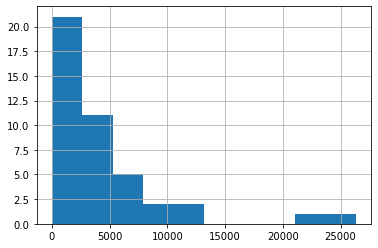

In [35]:
s60 = pd.Series(distances)
s60.hist()

<AxesSubplot:>

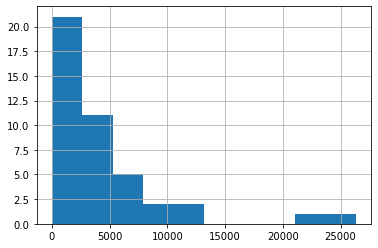

In [32]:
s14 = pd.Series(distances)
s14.hist()

<AxesSubplot:>

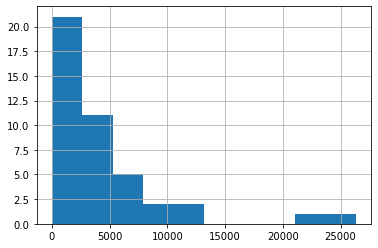

In [37]:
s10 = pd.Series(distances)
s10.hist()

<AxesSubplot:>

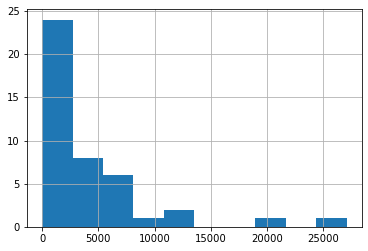

In [24]:
s7 = pd.Series(distances)
s7.hist()

<AxesSubplot:>

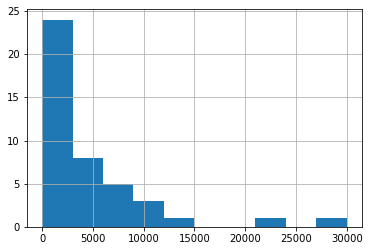

In [28]:
s1 = pd.Series(distances)
s1.hist()